---

## **Plotando Radiossondagens**

---


**OBJETIVO:** Aprender como baixar  e plotar dados de radiossondagens. Para isto será utilizado os dados da Universidade de [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).

---

**METODOLOGIA:** Será realizado o seguinte procedimento:

1.   Download dos dados de uma sondagem atmosférica para uma determinada data/horário;
2.   Tratamento dos dados (eliminação de dados ausentes);
3.   Cálculo dos índices termodinâmicos;
4.   Plotagem do Skew-T Log-P com a Hodógrafa;
5.   Salvar os dados em arquivo csv.


---


**OBSERVAÇÕES IMPORTANTES**:
1. Escolher a estação de radiossondagem. A escolha pode ser realizada inserindo o `código númerico` ou a `sigla` da estação.
2. Escolher a `data/horário` da radiossondagem.
3. Se apresentar algum problema na hora de importar o matplolib, vá em "Ambiente de execução" e click em "Reiniciar Ambiente de execução" e rodar do bloco de importação para frente (não precisa rodar o bloco de instalação das bibliotecas novamente).


---

- **Realizado por:** [Willy Hagi](https://taggo.one/willyhagi) da Meteonorte
- **Atualizado por:** Enrique V. Mattos - 19/06/2023

**Exemplo do gráfico que será gerado nessa aula:**

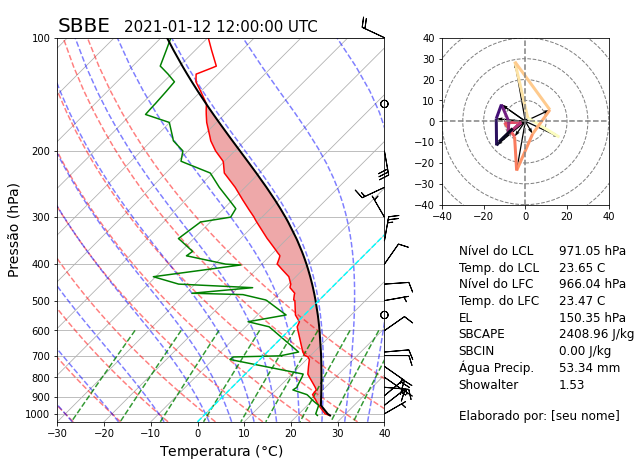

# **1° Passo:** Instalando o `Siphon`
O `Siphon` é um pacote que reúne uma coleção de funcionalidades que permitem o acesso de alguns bancos de dados meteorológicos. Para o nosso curso, vamos acessar o banco de dados de radiossondagens mantido pela [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).

Outros bancos de dados:
* *Integrated Global Radiosonde Archive version 2* (IGRA v2);
* *Iowa State’s upper air archive*;
* *National Data Buoy Center* (NDBC).

Vamos instalar o `Siphon` no **Colab**:

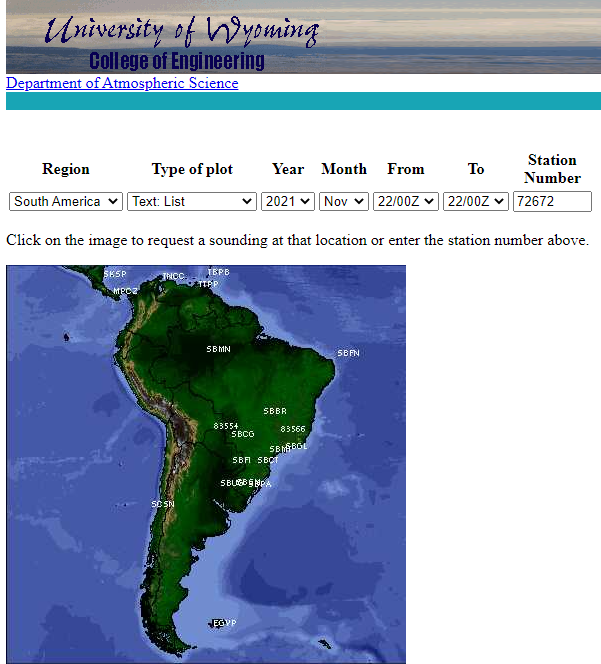

In [6]:
!pip install -q siphon

# **2° Passo:**  Instalando o `MetPy`
O [`MetPy`](https://unidata.github.io/MetPy/latest/index.html) foi um dos primeiros pacotes voltados exclusivamente para meteorologia no ecossistema científico do Python. É mantido até hoje pela UCAR/UNIDATA e por uma série de pesquisadores/programadores voluntários.

Vamos instalar o `MetPy` no **Colab**:

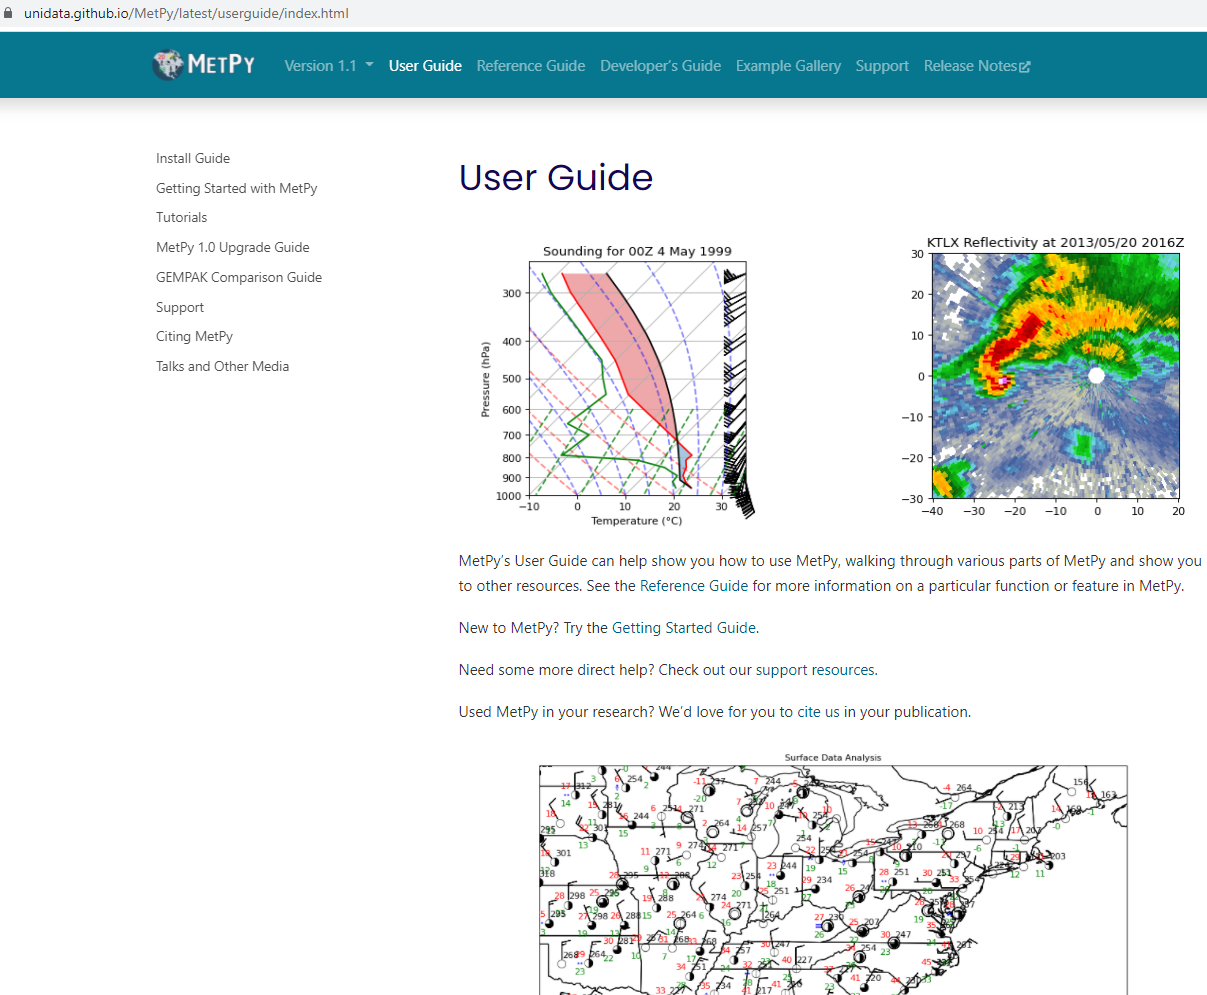

In [7]:
!pip install -q metpy

# **3° Passo:** Importando bibliotecas

In [8]:
import numpy as np                                           # biblioteca para trabalhar com matrizes
from datetime import datetime                                # biblioteca para trabalhar com datas

from siphon.simplewebservice.wyoming import WyomingUpperAir  # biblioteca siphon para baixar os dados de radiossodagens

from metpy.units import units                                # função unidades do metpy
import metpy.calc as mpcalc                                  # função que calcula variáveis termodinâmicas do metpy
from metpy.plots import Hodograph                            # função que plota hodrágrafa do metpy
from metpy.plots import SkewT                                # função que plota o gráfico Skew-T do metpy

import matplotlib.pyplot as plt                              # biblioteca para plotar gráficos
import matplotlib.gridspec as gridspec                       # função do matplotlib para plotar várias sub-figuras em uma figura
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # função do matplotlib para inserir eixos em uma figura

# **4° Passo:** Declarando a função

* Função que baixa e plota os dados de uma radissondagem

In [9]:
def plotar_painel(p, t, td, niveis, nome_estacao, hora, seu_nome, dir):

  pressao = p
  temperatura = t
  orvalho = td

  lcl_pressao, lcl_temperatura = mpcalc.lcl(pressao[0], temperatura[0], orvalho[0])  # calculando LCL
  lfc_pressao, lfc_temperatura = mpcalc.lfc(pressao, temperatura, orvalho)           # calculando LFC
  el_pressao, el_temperatura = mpcalc.el(pressao, temperatura, orvalho)              # calculando EL
  sbcape, sbcin = mpcalc.surface_based_cape_cin(pressao, temperatura, orvalho)       # calculando CAPE e CINE
  agua_precipitavel = mpcalc.precipitable_water(pressao, orvalho)                    # calculando ÁGUA PRECIPITÁVEL
  showalter = mpcalc.showalter_index(pressao, temperatura, orvalho)                  # calculando ÍNDICE SHOWALTER

  # criando a moldura da figura
  fig = plt.figure(figsize=(9, 9))

  # gridspec
  gs = gridspec.GridSpec(3, 3)
  skew = SkewT(fig, rotation=45, subplot=gs[0:2, :2])

  # temperaturas e barbelas de vento
  skew.plot(pressao, temperatura, color='red',)
  skew.plot(pressao, orvalho, color='green')
  skew.plot_barbs(pressao[niveis], vento_u[niveis], vento_v[niveis])

  # adicionar linhas relevantes no skew-t
  skew.plot_dry_adiabats()
  skew.plot_moist_adiabats()
  skew.plot_mixing_lines()

  # calcular o perfil da parcela de ar
  perfil = mpcalc.parcel_profile(pressao, temperatura[0], orvalho[0]).to('degC')
  skew.plot(pressao, perfil, color='black', linewidth=2)

  # cape e cin
  skew.shade_cin(pressao, temperatura, perfil, orvalho)
  skew.shade_cape(pressao, temperatura, perfil)

  # realçar isoterma de 0 degC
  skew.ax.axvline(0, color='cyan', linestyle='--')

  # ajuste do skew-t
  skew.ax.set_xlim(-30, 40)

  # legendas dos eixos
  plt.xlabel(r'Temperatura ($\degree$C)', fontsize=14)
  plt.ylabel(r'Pressão (hPa)', fontsize=14)
  plt.title(f'{nome_estacao}', fontsize=20, loc='left')
  plt.title(f'{hora} UTC', fontsize=15, loc='center')

  # incluir hodógrafo
  ax = fig.add_subplot(gs[0:1, -1])
  hodografo = Hodograph(ax, component_range=80.)
  hodografo.add_grid(increment=10)
  hodografo.plot_colormapped(vento_u[niveis], vento_v[niveis], pressao[niveis],
                           cmap='BuPu_r')
  hodografo.wind_vectors(vento_u[niveis], vento_v[niveis])

  # retirar ticks dos eixos
  #ax.set_xticks([])
  #ax.set_yticks([])

  # colocar limites em x e y
  ax.set_xlim(-40, 40)
  ax.set_ylim(-40, 40)

  # parâmetros termodinâmicos
  ax3 = fig.add_subplot(gs[1, -1])
  ax3.axis('off')

  # coluna 1
  ax3.text(0.1, 1,'Nível do LCL', size = 12)
  ax3.text(0.1, 0.9,'Temp. do LCL', size = 12)
  ax3.text(0.1, 0.8,'Nível do LFC', size = 12)
  ax3.text(0.1, 0.7,'Temp. do LFC', size = 12)
  ax3.text(0.1, 0.6,'EL', size = 12)
  ax3.text(0.1, 0.5,'SBCAPE', size = 12)
  ax3.text(0.1, 0.4,'SBCIN', size = 12)
  ax3.text(0.1, 0.3,'Água Precip.', size = 12)
  ax3.text(0.1, 0.2,'Showalter', size = 12)

  # coluna 2
  ax3.text(0.7, 1, '{:.2f} hPa'.format(np.array(lcl_pressao)), size = 12)
  ax3.text(0.7, 0.9, '{:.2f} C'.format(np.array(lcl_temperatura)), size = 12)
  ax3.text(0.7, 0.8, '{:.2f} hPa'.format(np.array(lfc_pressao)), size = 12)
  ax3.text(0.7, 0.7, '{:.2f} C'.format(np.array(lfc_temperatura)), size = 12)
  ax3.text(0.7, 0.6, '{:.2f} hPa'.format(np.array(el_pressao)), size = 12)
  ax3.text(0.7, 0.5, '{:.2f} J/kg'.format(np.array(sbcape)), size = 12)
  ax3.text(0.7, 0.4, '{:.2f} J/kg'.format(np.array(sbcin)), size = 12)
  ax3.text(0.7, 0.3, '{:.2f} mm'.format(np.array(agua_precipitavel)), size = 12)
  ax3.text(0.7, 0.2, '{:.2f}'.format(np.array(showalter)[0]), size = 12)
  ax3.text(0.1, 0.01, 'Elaborado por: ' + seu_nome, size = 12)

  plt.tight_layout()

  plt.savefig(f'skewt_{nome_estacao}_{hora}.jpg', dpi=300, bbox_inches='tight')

  plt.show()

#**PARTE 1:** Insira a **data** e **sigla** da estação

**SIGLA DA ESTAÇÃO**

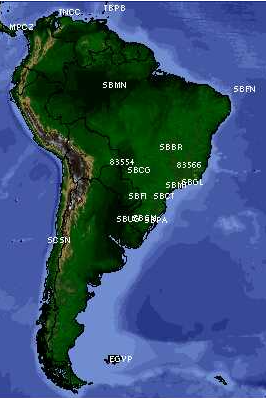

In [10]:
nome_estacao = 'SBVH' # 'SBCG'

# Exemplos de estações com sigla e código
# Galeao.........: SBGL ou 83746
# SP-Marte.......: SBMT ou 83779
# BR.............: SBBR ou 83378
# Curitiba.......: SBCT ou 83840
# Florianopolis..: SBFL ou 83899
# Uberlândia......:SBUL ou 83525

**DATA**

In [11]:
ano = 2019
mes = 4
dia = 20
hor = 00

#**PARTE 2:** Baixando os dados

**Baixando os dados da radiossondagem em formato de tabela (DataFrame)**

In [12]:
df_estacao = WyomingUpperAir.request_data(datetime(ano, mes, dia, hor), nome_estacao)

**Exibindo a tabela de dados**

In [13]:
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,942.0,652,23.4,22.8,220.0,1.0,0.642788,0.766044,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
1,930.0,734,26.0,21.5,333.0,2.0,0.907981,-1.782013,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
2,925.0,768,25.8,21.0,20.0,3.0,-1.026060,-2.819078,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
3,850.0,1510,21.0,17.0,30.0,7.0,-3.500000,-6.062178,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
4,754.0,2539,14.2,12.1,49.0,6.0,-4.528257,-3.936354,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,48.0,20896,-67.7,-86.9,335.0,15.0,6.339274,-13.594617,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
79,46.0,21154,-64.4,-86.0,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
80,45.7,21193,-63.9,-85.9,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
81,38.0,22333,-60.5,-90.4,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75


**Exibindo uma coluna da tabela de dados**

In [14]:
df_estacao['temperature']

0     23.4
1     26.0
2     25.8
3     21.0
4     14.2
      ... 
78   -67.7
79   -64.4
80   -63.9
81   -60.5
82   -60.5
Name: temperature, Length: 83, dtype: float64

**Plotando gráfico:** temperatura do ar

<Axes: >

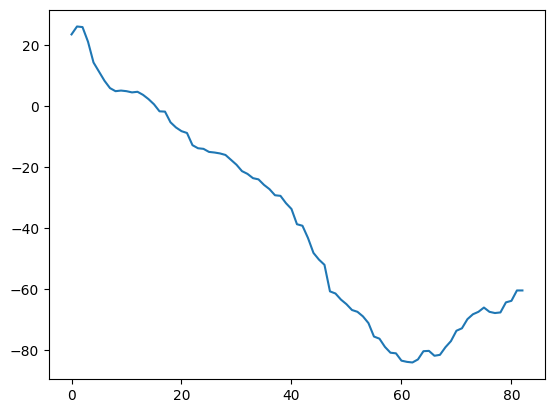

In [15]:
df_estacao['temperature'].plot()

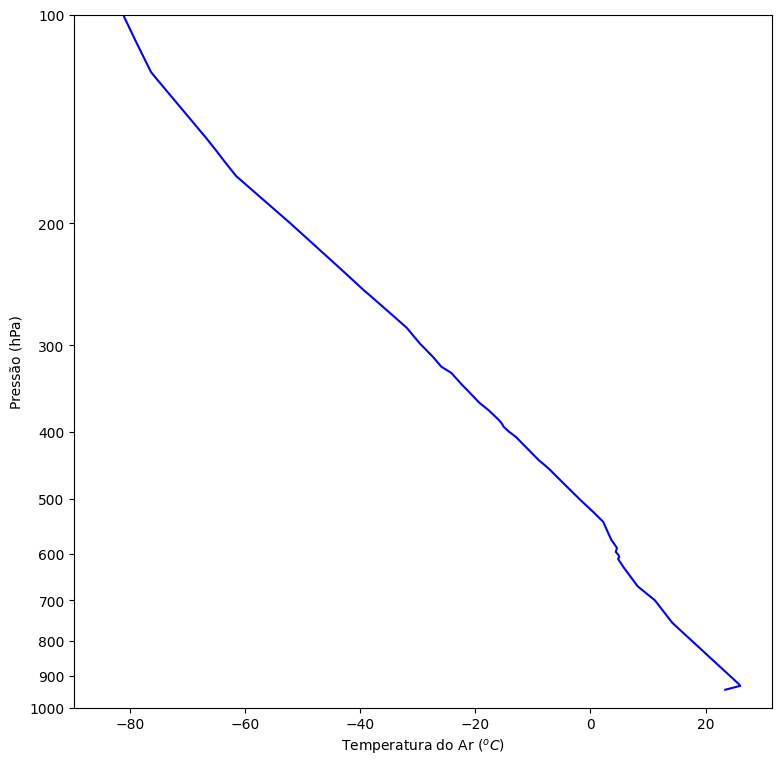

In [16]:
from matplotlib.ticker import (MultipleLocator, NullFormatter, ScalarFormatter)

fig, ax = plt.subplots(figsize=(9, 9))

# perfil de temperatura
ax.semilogy(df_estacao['temperature'], df_estacao['pressure'], color='blue')

# formatação dos eixos
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())

# ticks no eixo y
ax.set_yticks(np.linspace(100, 1000, 10))

# limite em y (imitando o limite do Skew-T)
ax.set_ylim(100, 1000)

# inverter eixo y
plt.gca().invert_yaxis()

ax.set_ylabel('Pressão (hPa)')
ax.set_xlabel('Temperatura do Ar ($^{o}C$)')

plt.show()

#**PARTE 3:** Tratamento dos dados

**Eliminando dados NaN (*Not A Number* = Não é número)**

In [17]:
# retirar nan da tabela
df_estacao = df_estacao.dropna()

In [18]:
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,942.0,652,23.4,22.8,220.0,1.0,0.642788,0.766044,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
1,930.0,734,26.0,21.5,333.0,2.0,0.907981,-1.782013,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
2,925.0,768,25.8,21.0,20.0,3.0,-1.026060,-2.819078,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
3,850.0,1510,21.0,17.0,30.0,7.0,-3.500000,-6.062178,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
4,754.0,2539,14.2,12.1,49.0,6.0,-4.528257,-3.936354,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,48.1,20883,-67.9,-86.9,337.0,15.0,5.860967,-13.807573,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
78,48.0,20896,-67.7,-86.9,335.0,15.0,6.339274,-13.594617,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
79,46.0,21154,-64.4,-86.0,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
80,45.7,21193,-63.9,-85.9,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75


In [19]:
df_estacao.describe()

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station_number,latitude,longitude,elevation,pw
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.0,8.200000e+01,8.200000e+01,82.0,82.00
mean,305.179268,11585.682927,-37.717073,-47.485366,120.841463,11.902439,-5.829836,0.566263,83208.0,-1.270000e+01,-6.010000e+01,652.0,47.75
std,238.570540,6078.000601,34.321713,34.088093,88.192476,7.270114,10.598603,7.014986,0.0,1.787288e-15,2.144746e-14,0.0,0.00
min,38.000000,652.000000,-84.100000,-90.400000,0.000000,0.000000,-29.130471,-15.939115,83208.0,-1.270000e+01,-6.010000e+01,652.0,47.75
25%,88.950000,6858.500000,-68.200000,-83.525000,50.250000,8.000000,-10.625184,-2.977722,83208.0,-1.270000e+01,-6.010000e+01,652.0,47.75
50%,263.000000,10692.500000,-36.300000,-43.350000,99.500000,10.000000,-6.674351,-0.000000,83208.0,-1.270000e+01,-6.010000e+01,652.0,47.75
75%,443.000000,17332.250000,-8.450000,-25.150000,197.500000,15.000000,0.840428,5.289686,83208.0,-1.270000e+01,-6.010000e+01,652.0,47.75
max,942.000000,22333.000000,26.000000,22.800000,337.000000,31.000000,14.500925,20.784610,83208.0,-1.270000e+01,-6.010000e+01,652.0,47.75


In [20]:
df_estacao_novo = df_estacao[ df_estacao['temperature'] < 29.2]

In [21]:
df_estacao_novo

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,942.0,652,23.4,22.8,220.0,1.0,0.642788,0.766044,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
1,930.0,734,26.0,21.5,333.0,2.0,0.907981,-1.782013,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
2,925.0,768,25.8,21.0,20.0,3.0,-1.026060,-2.819078,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
3,850.0,1510,21.0,17.0,30.0,7.0,-3.500000,-6.062178,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
4,754.0,2539,14.2,12.1,49.0,6.0,-4.528257,-3.936354,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,48.1,20883,-67.9,-86.9,337.0,15.0,5.860967,-13.807573,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
78,48.0,20896,-67.7,-86.9,335.0,15.0,6.339274,-13.594617,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
79,46.0,21154,-64.4,-86.0,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
80,45.7,21193,-63.9,-85.9,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75


In [22]:
type(df_estacao)

pandas.core.frame.DataFrame

**Atribuindo as variáveis que serão utilizadas e inserindo unidades nos dados**
- **Values**: tranforma de DataFrame para vetor (array unidimensional)

In [23]:
df_estacao['pressure']

0     942.0
1     930.0
2     925.0
3     850.0
4     754.0
      ...  
77     48.1
78     48.0
79     46.0
80     45.7
81     38.0
Name: pressure, Length: 82, dtype: float64

In [24]:
df_estacao['pressure'].values

array([942. , 930. , 925. , 850. , 754. , 700. , 668. , 628. , 610. ,
       606. , 601. , 596. , 588. , 572. , 539. , 522. , 501. , 500. ,
       468. , 453. , 444. , 440. , 407. , 401. , 400. , 393. , 390. ,
       387. , 383. , 372. , 363. , 348. , 342. , 332. , 329. , 322. ,
       312. , 300. , 299. , 283. , 274. , 252. , 250. , 233. , 214. ,
       206. , 200. , 173. , 171. , 163. , 157. , 150. , 148. , 143. ,
       136. , 123. , 121. , 109. , 101. , 100. ,  90. ,  88.6,  83.6,
        82. ,  78. ,  77.9,  73.4,  73. ,  70. ,  67. ,  62. ,  61. ,
        57. ,  55. ,  54. ,  52.4,  50. ,  48.1,  48. ,  46. ,  45.7,
        38. ])

In [25]:
# registrando unidades
pressao = df_estacao['pressure'].values * units('hPa')

temperatura = df_estacao['temperature'].values * units('celsius')
orvalho = df_estacao['dewpoint'].values * units('celsius')
vento_u = df_estacao['u_wind'].values * units('m/s')
vento_v = df_estacao['v_wind'].values * units('m/s')

In [26]:
pressao

Magnitude,[942.0 930.0 925.0 850.0 754.0 700.0 668.0 628.0 610.0 606.0 601.0 596.0 588.0 572.0 539.0 522.0 501.0 500.0 468.0 453.0 444.0 440.0 407.0 401.0 400.0 393.0 390.0 387.0 383.0 372.0 363.0 348.0 342.0 332.0 329.0 322.0 312.0 300.0 299.0 283.0 274.0 252.0 250.0 233.0 214.0 206.0 200.0 173.0 171.0 163.0 157.0 150.0 148.0 143.0 136.0 123.0 121.0 109.0 101.0 100.0 90.0 88.6 83.6 82.0 78.0 77.9 73.4 73.0 70.0 67.0 62.0 61.0 57.0 55.0 54.0 52.4 50.0 48.1 48.0 46.0 45.7 38.0]
Units,hectopascal


In [27]:
temperatura

Magnitude,[23.4 26.0 25.8 21.0 14.2 11.2 8.2 5.8 4.8 5.0 4.8 4.4 4.6 3.6 2.2 0.5 -1.8 -1.9 -5.4 -7.1 -8.3 -8.9 -12.9 -13.9 -14.1 -15.1 -15.3 -15.6 -16.1 -17.7 -19.3 -21.4 -22.3 -23.7 -24.1 -25.9 -27.3 -29.3 -29.5 -31.9 -33.8 -38.8 -39.3 -43.3 -48.2 -50.4 -52.1 -60.8 -61.5 -63.5 -65.0 -66.9 -67.5 -69.0 -71.2 -75.6 -76.3 -79.0 -80.9 -81.1 -83.5 -83.9 -84.1 -83.1 -80.4 -80.3 -81.9 -81.6 -79.1 -77.1 -73.7 -72.9 -69.9 -68.3 -67.5 -66.1 -67.5 -67.9 -67.7 -64.4 -63.9 -60.5]
Units,degree_Celsius


In [28]:
orvalho

Magnitude,[22.8 21.5 21.0 17.0 12.1 8.2 6.5 3.7 -2.2 -9.0 -10.2 -3.6 -8.4 -4.4 -13.8 -16.0 -18.8 -18.9 -28.4 -33.1 -28.1 -25.9 -43.9 -28.7 -26.1 -23.1 -20.3 -24.9 -31.1 -34.7 -30.3 -42.3 -47.3 -33.7 -38.1 -37.9 -30.0 -31.2 -31.4 -35.8 -37.6 -42.4 -42.8 -46.6 -51.9 -54.3 -56.1 -65.0 -65.7 -67.8 -69.3 -71.3 -71.9 -73.4 -75.7 -80.2 -80.9 -83.7 -85.7 -85.9 -88.3 -88.7 -88.7 -87.8 -85.4 -85.3 -86.9 -86.7 -85.1 -84.7 -83.8 -83.7 -83.0 -82.6 -82.4 -82.1 -85.5 -86.9 -86.9 -86.0 -85.9 -90.4]
Units,degree_Celsius


In [29]:
vento_u

Magnitude,[0.6427876096865393 0.9079809994790939 -1.0260604299770062 -3.4999999999999996 -4.528257481336632 -5.196152422706632 -6.657395614066075 -6.99573578913367 -7.969557584733964 -7.940369213130577 -7.901506724761102 -7.853017467581312 -7.7274066103125465 -8.344654691101088 -7.986355100472927 -7.0710678118654755 -7.070663706551934 -7.070663706551934 -9.659258262890683 -12.715918809539472 -14.772116295183121 -14.772116295183121 -11.643548715311958 -10.62518408917975 -10.62518408917975 -8.090169943749475 -6.9465837045899725 -5.7357643635104605 -5.877852522924732 -6.293203910498374 -7.2166493188955805 -7.778174593052022 -6.691306063588582 -4.814520185216386 -4.702282018339785 -3.7094348496324345 -2.2699524986977337 -1.0260604299770062 -0.7257656867990032 7.878462024097665 7.071067811865475 0.90630778703665 1.9318516525781366 5.7378285357782115 9.396926207859085 10.39230484541326 12.21600407021681 14.0 13.946725773284438 14.5009245925864 9.526279441628823 3.0781812899310177 1.7364817766693048 6.000000000000002 5.362311101832845 10.284601754984628 8.75564727347092 -11.999999999999998 -22.936257240091766 -24.248711305964285 -23.908672754201895 -24.0 -24.939101256495604 -24.90486745229364 -29.13047124436316 -29.13047124436316 -17.219847953696352 -16.3135401666597 -21.612930278075893 -21.665770566268577 -8.48528137423857 -4.8296291314453415 -9.396926207859083 -17.38666487320323 -21.665770566268577 -17.820130483767358 -1.3944918839625307 5.860966927339108 6.339273926110488 -0.0 -0.0 -0.0]
Units,meter/second


In [30]:
vento_v

Magnitude,[0.766044443118978 -1.7820130483767356 -2.8190778623577253 -6.062177826491071 -3.9363541739430437 -3.000000000000001 -2.163118960624632 -0.24429647691750755 0.6972459419812659 0.9749547472411789 1.2514757203218465 1.5264719630123584 2.070552360820167 3.3714593407432085 6.018150231520484 7.071067811865475 8.426488874308756 8.426488874308756 -2.5881904510252074 -2.702851980630873 -2.604722665003956 -2.604722665003956 -2.903062747196012 -2.847009496127728 -2.847009496127728 -5.877852522924732 -7.193398003386512 -8.191520442889917 -8.090169943749475 -7.771459614569709 -8.301805382450492 -7.778174593052023 -7.431448254773942 -6.389084080378343 -6.47213595499958 -5.936336673094981 -4.455032620941839 -2.8190778623577253 -2.9108871788279895 -1.3891854213354398 7.071067811865477 0.42261826174069916 0.5176380902050413 1.7542302283364226 3.4202014332566852 6.000000000000005 4.446261863233691 2.5717582782094417e-15 1.2201803984672155 6.761892187851187 5.500000000000005 8.457233587073176 9.84807753012208 10.392304845413264 4.499513267805776 12.256711089903648 14.57184411193591 20.784609690826528 16.060140217829293 13.999999999999993 -2.0917378259437953 -1.4695761589768238e-15 -1.743911843603131 -2.1788935686914535 10.60262444309573 10.60262444309573 8.029746973073287 7.607128711332588 7.86646329649038 3.8202599086724667 -8.485281374238571 1.2940952255126041 -3.4202014332566884 4.658742811845375 3.8202599086724667 -9.079809994790937 -15.939115169467929 -13.807572801786604 -13.594616805549752 -0.0 -0.0 -0.0]
Units,meter/second


**Criando um intervalo de níveis de pressão através de `np.arange()` entre os níveis de `1000 hPa a 100 hPa`**

In [31]:
np.arange(1, 150, 1)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149])

In [32]:
niveis = np.arange(100, 1050, 50) * units('hPa') # mbar para milibar
niveis

Magnitude,[ 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000]
Units,hectopascal


In [33]:
len(niveis)

19

In [34]:
pressao

Magnitude,[942.0 930.0 925.0 850.0 754.0 700.0 668.0 628.0 610.0 606.0 601.0 596.0 588.0 572.0 539.0 522.0 501.0 500.0 468.0 453.0 444.0 440.0 407.0 401.0 400.0 393.0 390.0 387.0 383.0 372.0 363.0 348.0 342.0 332.0 329.0 322.0 312.0 300.0 299.0 283.0 274.0 252.0 250.0 233.0 214.0 206.0 200.0 173.0 171.0 163.0 157.0 150.0 148.0 143.0 136.0 123.0 121.0 109.0 101.0 100.0 90.0 88.6 83.6 82.0 78.0 77.9 73.4 73.0 70.0 67.0 62.0 61.0 57.0 55.0 54.0 52.4 50.0 48.1 48.0 46.0 45.7 38.0]
Units,hectopascal


**E esse intervalo de `niveis` vai servir para "filtrar" os dados de vento para o diagrama, com o uso de `mpcalc.resample_nn_1d()`.**

In [35]:
len(pressao)

82

In [36]:
len(niveis)

19

In [37]:
niveis = mpcalc.resample_nn_1d(pressao, niveis)
niveis

[59, 51, 46, 42, 37, 31, 24, 19, 17, 14, 10, 6, 5, 4, 3, 2, 0]

**Extraindo o nome e data da estação**

In [38]:
# para o título
nome = df_estacao['station'][0]
dia = df_estacao['time'][0]

In [39]:
nome

'SBVH'

In [40]:
dia

Timestamp('2019-04-20 00:00:00')

#**PARTE 4:** Plotando o gráfico

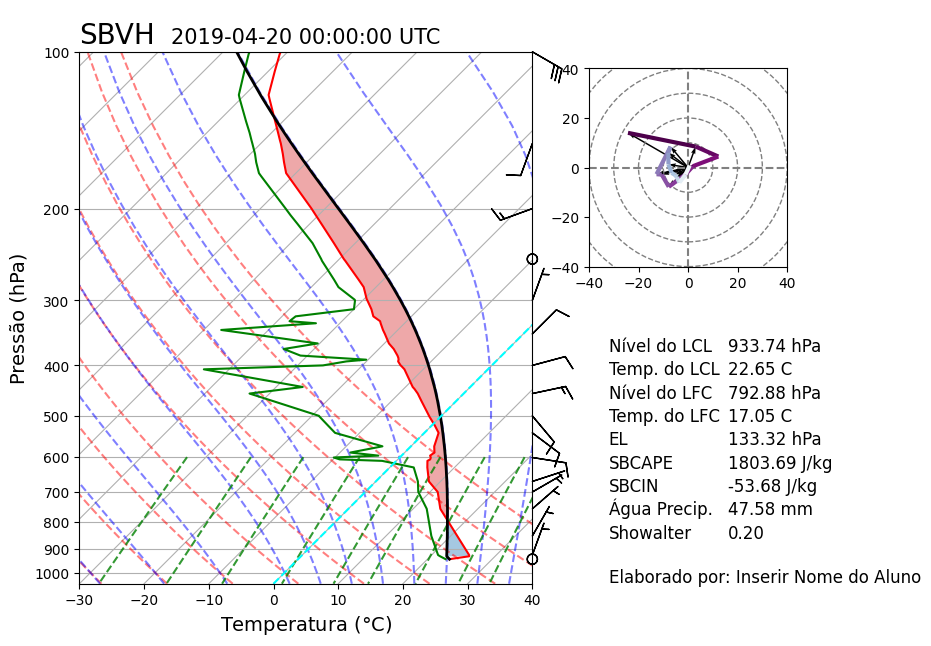

In [41]:
# plotar painel termodinâmico com a função
plotar_painel(pressao, temperatura, orvalho, niveis, nome_estacao, dia, 'Inserir Nome do Aluno', f'{dir}output/')

# Segue o link de um manual explicando os termos técnicos do Gráfico Skew-T Log-P: [Manual Skew-T](https://www.dropbox.com/s/sdm5etisv065lt7/Manual%20Informativo%20-%20SKEW-T.pdf?dl=0)

#**PARTE 5:** Gerando outros parâmetros meteorológicos e salvando num arquivo `CSV`

- Outro aspecto importante da análise de radiossondagens é o cálculo de algumas variáveis de interesse, como a própria Umidade Relativa (que é colocada na tabela no portal da Wyoming, mas que não é disponibilizada pelo Siphon), Temperatura Potencial e outras.

- O `mpcalc` também possui várias funções para o cálculo dessas variáveis e, novamente, a lista é extensa.

- Por exemplo, podemos calcular:
   - Umidade Relativa a partir da Temperatura do Ponto de Orvalho: `.relative_humidity_from_dewpoint()`, que precisa da temperatura do ar e temperatura do ponto de orvalho como argumentos (e precisa multiplicar por 100 ao final).


**- Umidade relativa**

In [42]:
umidade_relativa = mpcalc.relative_humidity_from_dewpoint(temperatura, orvalho) * 100
umidade_relativa

Magnitude,[96.43299493982272 76.25336374067334 74.83051734537513 77.89701483888555 87.1816385453385 81.76288751383673 89.02601979045707 86.36247593316368 60.490179745779805 35.56886496276015 32.82011547633743 56.05779657324375 38.32921635902852 55.84424987544503 29.528862418557416 27.83337652181226 26.006986303552992 25.97690461671622 14.482183441323466 10.549036253192998 18.60796255916287 23.863037457115922 5.514110732252007 27.494265706263832 35.51218660011388 50.47044678307382 65.54897890037508 44.789317676436404 26.283421811239677 21.194632715211412 37.15172319296157 13.367308816210146 8.38677501588245 39.33543301989026 26.271721855380882 31.534849116984017 77.74948456530507 83.54615028962961 83.51794285050157 68.26243414855698 68.47694991068222 68.64119149482646 69.24966633239347 69.75391436531226 65.34814400052082 63.17255178242751 61.88909263640474 57.45745791949252 57.20970624256372 55.71029816954031 55.156208693788834 53.658203554944215 53.42762667815043 52.84506930138683 51.186961502265625 48.58449209377436 48.28696014658355 46.33414247756719 44.71266006193561 44.62269962722885 43.531000663487106 43.346866476352616 44.83817614725098 44.497805593229685 43.41804310951044 43.46314549364331 42.737019402708434 42.13059147825544 37.10730596637293 29.010851769057716 20.138033263446093 18.185868190688034 13.226661527646892 11.274389314793822 10.42391241953263 9.03238552820815 6.172391703901454 5.115735658371836 4.9751013750494355 3.7079941726956784 3.5287508602482553 1.0134871919548436]
Units,dimensionless


**- Razão de mistura**
- Razão de mistura a partir da Umidade Relativa: `.mixing_ratio_from_relative_humidity()`, cujos argumentos são pressão, temperatura e umidade relativa.

In [43]:
razao_mistura = mpcalc.mixing_ratio_from_relative_humidity(pressao, temperatura, umidade_relativa)
razao_mistura

Magnitude,[1.8897047391239254 1.7785053426286972 1.7336514992339338 1.4595270490837726 1.189262866143454 0.9844167390979798 0.9158308408748621 0.8003291042108033 0.538040342588703 0.3230299936180809 0.2963592258471703 0.4962233157581505 0.34889024379381145 0.4868254752816225 0.24724188880904693 0.21274984385829335 0.17487021269809822 0.17372239674148998 0.07948865917368728 0.05248550376224443 0.08603356265932273 0.10621513269414339 0.019273833645147342 0.08989488426985918 0.11450586751106331 0.152528273878327 0.19634424680539395 0.13187601536096072 0.07500568110276568 0.05443376783888004 0.0853120553010326 0.026692496945391945 0.01574630168797637 0.06719409817624444 0.043696552349196734 0.04554958537308639 0.10195116998027631 0.09458656004311775 0.09310387396383886 0.06398716446610556 0.05512979260473139 0.0363854294103089 0.0351441594137641 0.024925741337498423 0.014824632982681015 0.011582102020064483 0.00958828062520694 0.0035277080643032204 0.0032458248414838587 0.002549838272939846 0.0021439653724923814 0.0016843608683034066 0.001564304069713981 0.0012978288195864952 0.0009647972757962621 0.0005262528166769608 0.00047758603517040197 0.00033346112275703214 0.00025582513538582446 0.0002495956438285481 0.00018182038118433574 0.0001719253737478832 0.0001822080203321291 0.00021814033192179798 0.00034885227091486056 0.0003553610671176322 0.00028564620503676114 0.00029745538016624014 0.00040928426688828355 0.0004578956294016526 0.0005764648581356759 0.0005958812563421192 0.0007171817033061486 0.0007945039440872811 0.0008365455476902455 0.0009059948524713981 0.0005349837069913738 0.00043594758436480877 0.0004368576287027398 0.0005333934012542167 0.0005462921786350176 0.00029454650188685637]
Units,dimensionless


**- Temperatura virtual** `.virtual_temperature()`, cujos argumentos são temperatura e razão de mistura.

In [44]:
temperatura_virtual = mpcalc.virtual_temperature(temperatura, razao_mistura)
temperatura_virtual

Magnitude,[141.27437889175468 142.38954008396678 141.03866451709206 127.09878354193472 109.07944951609568 96.93938176191665 89.94967422466726 81.174436914039 63.900995847112654 46.27938611982739 43.42253489034533 60.350373092777374 48.26638969285085 58.678479085876404 35.3770259311616 29.679273993893673 22.749168011895847 22.502885065172734 6.583883367935641 0.9643156297555038 4.452802820527211 6.522074747924535 -9.908775729328397 -0.90279001427308 2.0774470008240655 5.657910615206106 10.422321229631564 2.639356851821617 -5.1986065372271355 -9.684400581985074 -7.17130841929702 -17.421683787235764 -19.936321360402246 -14.153322978827077 -17.762171593455264 -19.352777485707634 -13.47449246345542 -16.491947864177234 -16.885973438515407 -23.081295195573887 -26.198576808752023 -33.79905393277406 -34.474184595965 -39.90232997925884 -46.202623415381055 -48.84980986446331 -50.823949206706004 -60.3462709958134 -61.08378569889217 -63.17589738285761 -64.72932691473511 -66.68919582198635 -67.3047675258077 -68.83916353078618 -71.08168436774767 -75.53684263743037 -76.2428836189982 -78.96066140781221 -80.87011319576811 -81.07087111001115 -83.47904452731527 -83.88022656081944 -84.07906629722896 -83.07480640615287 -80.35914309451744 -80.25835947546511 -81.86680391465072 -81.56537770696727 -79.0517450365578 -77.04545994949441 -73.63015463332798 -72.82751393142269 -69.81146206141875 -68.20115194664592 -67.39551927977891 -65.98608296269472 -67.43316283841412 -67.84563628088608 -67.64546976200216 -64.33235689390904 -63.83055607339617 -60.46193968641239]
Units,degree_Celsius


**- Temperatura potencial equivalente**

In [45]:
temperatura_potencial_equiv = mpcalc.equivalent_potential_temperature(pressao,
                                                                      temperatura,
                                                                      orvalho)
temperatura_potencial_equiv

Magnitude,[357.5698901038249 358.47953579364463 357.4359279195086 352.2665630202019 348.1689253517822 345.7287868767701 344.6442125625782 344.26001369712685 337.6584693574535 331.7256319343839 331.42380468138634 338.1130370412691 334.96376066263787 340.85725543252613 337.1327956996422 336.994796982525 336.8391124396266 336.8688101141096 335.6008914630693 335.61722585211726 337.23635242014666 338.06056398311586 337.2517006134072 340.00344838563126 340.8635430430292 342.6109686686342 344.6308559023291 342.72674823216204 341.0343304952862 340.987728887686 342.36916976533774 341.45983869508575 341.5024592356566 344.4622310633701 343.91793580158054 343.6071535375625 346.8594090609126 347.64608767492007 347.63786074054605 348.57654947045944 348.70250306684517 348.955190737819 348.9555763873744 349.5517262941789 350.1042096656407 350.3395177692643 350.5302524836444 350.7174050485078 350.711963299862 352.1549107980927 353.38344114642973 354.7293964462711 355.0509230836873 355.92660158730075 357.1603791416025 359.53171601726456 359.937309362067 365.74615453196964 370.1370373314426 370.8043330943055 377.3572265256715 378.2513228112251 384.17559010548734 388.3480162544299 399.5410169948471 399.8952260784824 403.37310519084804 404.63780673806235 414.87007210198334 424.42761017722364 441.4709239036282 445.3069877187789 460.83021894625983 469.2273368915778 473.53877562792013 480.8820875476201 484.04590409651007 488.4745022007878 489.2413798495943 503.18853232783124 505.33857181798885 541.3292152035649]
Units,kelvin


**- Unindo os parâmetros calculados as variáveis originais**

In [46]:
df_estacao.insert(4, 'Umidade Relativa', umidade_relativa)
df_estacao.insert(5, 'Temperatura Virtual', temperatura_virtual)
df_estacao.insert(6, 'Temperatura Potencial Eq.', temperatura_potencial_equiv)

In [47]:
df_estacao

,pressure,height,temperature,dewpoint,Umidade Relativa,Temperatura Virtual,Temperatura Potencial Eq.,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,942.0,652,23.4,22.8,96.432995,141.274379,357.569890,220.0,1.0,0.642788,0.766044,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
1,930.0,734,26.0,21.5,76.253364,142.389540,358.479536,333.0,2.0,0.907981,-1.782013,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
2,925.0,768,25.8,21.0,74.830517,141.038665,357.435928,20.0,3.0,-1.026060,-2.819078,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
3,850.0,1510,21.0,17.0,77.897015,127.098784,352.266563,30.0,7.0,-3.500000,-6.062178,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
4,754.0,2539,14.2,12.1,87.181639,109.079450,348.168925,49.0,6.0,-4.528257,-3.936354,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,48.1,20883,-67.9,-86.9,5.115736,-67.845636,488.474502,337.0,15.0,5.860967,-13.807573,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
78,48.0,20896,-67.7,-86.9,4.975101,-67.645470,489.241380,335.0,15.0,6.339274,-13.594617,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
79,46.0,21154,-64.4,-86.0,3.707994,-64.332357,503.188532,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
80,45.7,21193,-63.9,-85.9,3.528751,-63.830556,505.338572,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75


**- Renomeando as colunas da tabela**

In [48]:
df_estacao.columns = ['Pressao Atm (hPa)', 'Altura (m)', 'Temperatura (C)',
                      'Temperatura Pto. de Orvalho (C)', 'Umidade Relativa (%)',
                      'Temperatura Virtual (K)', 'Temperatura Potencial Eq. (K)',
                      'Direcao do Vento', 'Velocidade (m/s)', 'Vento Zonal (m/s)',
                      'Vento Meridional (m/s)', 'Estacao', 'Codigo', 'Tempo',
                      'Latitude', 'Longitude', 'Elevacao', 'Agua Precipitavel']

In [49]:
df_estacao

,Pressao Atm (hPa),Altura (m),Temperatura (C),Temperatura Pto. de Orvalho (C),Umidade Relativa (%),Temperatura Virtual (K),Temperatura Potencial Eq. (K),Direcao do Vento,Velocidade (m/s),Vento Zonal (m/s),Vento Meridional (m/s),Estacao,Codigo,Tempo,Latitude,Longitude,Elevacao,Agua Precipitavel
0,942.0,652,23.4,22.8,96.432995,141.274379,357.569890,220.0,1.0,0.642788,0.766044,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
1,930.0,734,26.0,21.5,76.253364,142.389540,358.479536,333.0,2.0,0.907981,-1.782013,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
2,925.0,768,25.8,21.0,74.830517,141.038665,357.435928,20.0,3.0,-1.026060,-2.819078,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
3,850.0,1510,21.0,17.0,77.897015,127.098784,352.266563,30.0,7.0,-3.500000,-6.062178,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
4,754.0,2539,14.2,12.1,87.181639,109.079450,348.168925,49.0,6.0,-4.528257,-3.936354,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,48.1,20883,-67.9,-86.9,5.115736,-67.845636,488.474502,337.0,15.0,5.860967,-13.807573,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
78,48.0,20896,-67.7,-86.9,4.975101,-67.645470,489.241380,335.0,15.0,6.339274,-13.594617,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
79,46.0,21154,-64.4,-86.0,3.707994,-64.332357,503.188532,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75
80,45.7,21193,-63.9,-85.9,3.528751,-63.830556,505.338572,0.0,0.0,-0.000000,-0.000000,SBVH,83208,2019-04-20,-12.7,-60.1,652.0,47.75


**- Salvando em um `DataFrame`**

In [51]:
df_estacao.to_csv(f'{nome_estacao}_{dia}.csv', sep=';')